### Importing the libraries

In [48]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, cross_val_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_curve, roc_auc_score, auc
from xgboost import XGBClassifier, plot_importance

### Load the dataset & Preprocessing

In [49]:
# Load the dataset
file_path = './dataset/BankChurners_transformed.csv'
df = pd.read_csv(file_path)

In [50]:
# Data Preprocessing
X_classification = df.drop(columns=['Attrition_Flag'])
y_classification = df['Attrition_Flag']

# Convert target labels to numeric values
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y_classification)


# A. Classification Task

## 1. RandomForest

In [51]:
label_encoder = LabelEncoder()
y_numeric = label_encoder.fit_transform(y_classification)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_numeric, test_size=0.2, random_state=42)

# Train a RandomForest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

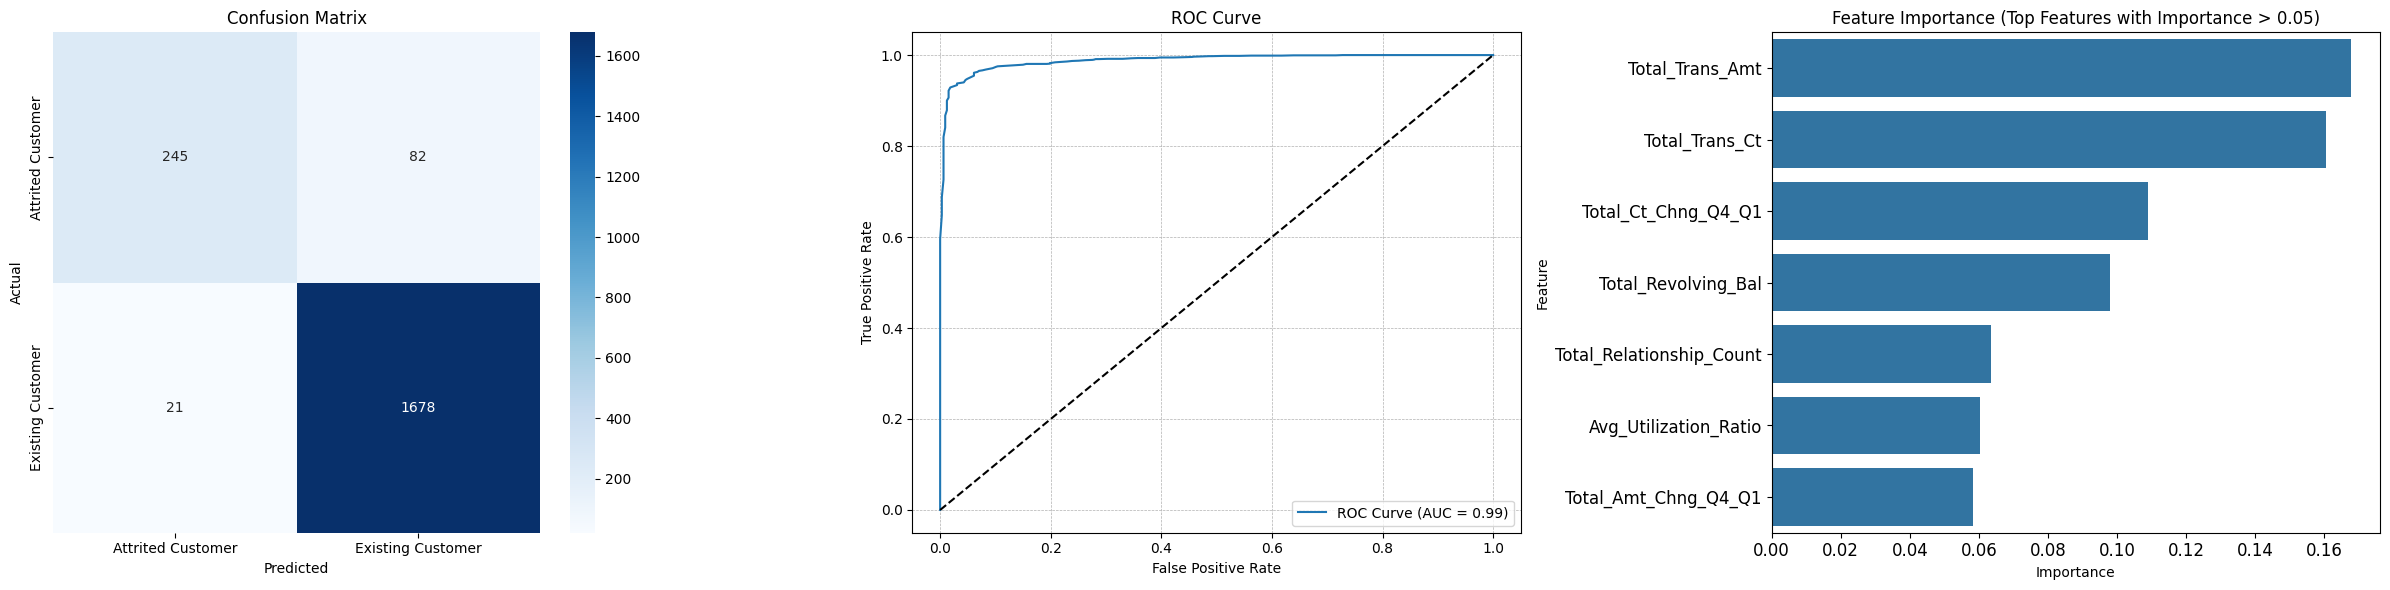

Classification Report:
              precision    recall  f1-score      support
0              0.921053  0.749235  0.826307   327.000000
1              0.953409  0.987640  0.970223  1699.000000
accuracy       0.949161  0.949161  0.949161     0.949161
macro avg      0.937231  0.868438  0.898265  2026.000000
weighted avg   0.948187  0.949161  0.946994  2026.000000


In [52]:
# Evaluate the Classification Model
y_pred = rf_model.predict(X_test)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

# Get the predicted probabilities for the positive class
y_prob = rf_model.predict_proba(X_test)[:, 1]

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Feature importance
feature_importances = rf_model.feature_importances_
features = X_classification.columns

# Create a DataFrame to associate feature names with importance scores
feature_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_df = feature_df.sort_values(by='Importance', ascending=False)

# Filter to keep only features with importance above 0.05
feature_df_filtered = feature_df[feature_df['Importance'] > 0.05]

# Plot Confusion Matrix, ROC Curve, and Feature Importance side by side
fig, axs = plt.subplots(1, 3, figsize=(24, 6))

# Confusion Matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axs[0], xticklabels=['Attrited Customer', 'Existing Customer'], yticklabels=['Attrited Customer', 'Existing Customer'])
axs[0].set_ylabel('Actual')
axs[0].set_xlabel('Predicted')
axs[0].set_title('Confusion Matrix')

# ROC Curve
axs[1].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axs[1].plot([0, 1], [0, 1], 'k--')  # Diagonal line representing random performance
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve')
axs[1].legend()
axs[1].grid(visible=True, linestyle='--', linewidth=0.5)

# Feature Importance
sns.barplot(x='Importance', y='Feature', data=feature_df_filtered, ax=axs[2])
axs[2].set_title('Feature Importance (Top Features with Importance > 0.05)')
axs[2].set_xlabel('Importance')
axs[2].set_ylabel('Feature')
axs[2].tick_params(axis='both', labelsize=12)

plt.tight_layout()
plt.show()

# Convert classification report into a DataFrame and display it
class_report_df = pd.DataFrame(class_report).transpose()
print("Classification Report:")
print(class_report_df)


## Analysis
  
1. Accuracy:
- An accuracy of 94.9% indicates that the model is performing well across the entire dataset, correctly classifying most samples
2. Precision, Recall, and F1 Score:
- Attrited Customer:
    - Precision of 92.1% means that out of all customers predicted as attrited, 92.1% are actually attrited
    - Recall of 74.9% indicates that the model successfully identified 74.9% of all actual attrited customers
    - The F1 score of 82.6% balances precision and recall, showing good performance overall
- Existing Customer:
    - Precision of 95.3% indicates that out of all customers predicted to be existing, 95.3% were correctly classified
    - Recall of 98.8% means that the model identified 98.8% of all actual existing customers
    - The high F1 score of 97% reflects strong precision and recall
3. Misclassifications:
- False Negatives (82): Attrited customers predicted as existing could lead to customer churn if they don't receive targeted retention strategies
- False Positives (21): Existing customers predicted as attrited could receive unnecessary retention efforts, potentially affecting customer satisfaction
4. Overall:
- The model is well-balanced, but it performs slightly better for existing customers due to class imbalance.
- Addressing the imbalance could involve oversampling the attrited customer class or undersampling the existing customer class.

## 2. XGBoost model with RandomOverSampler for the imbalanced datasets

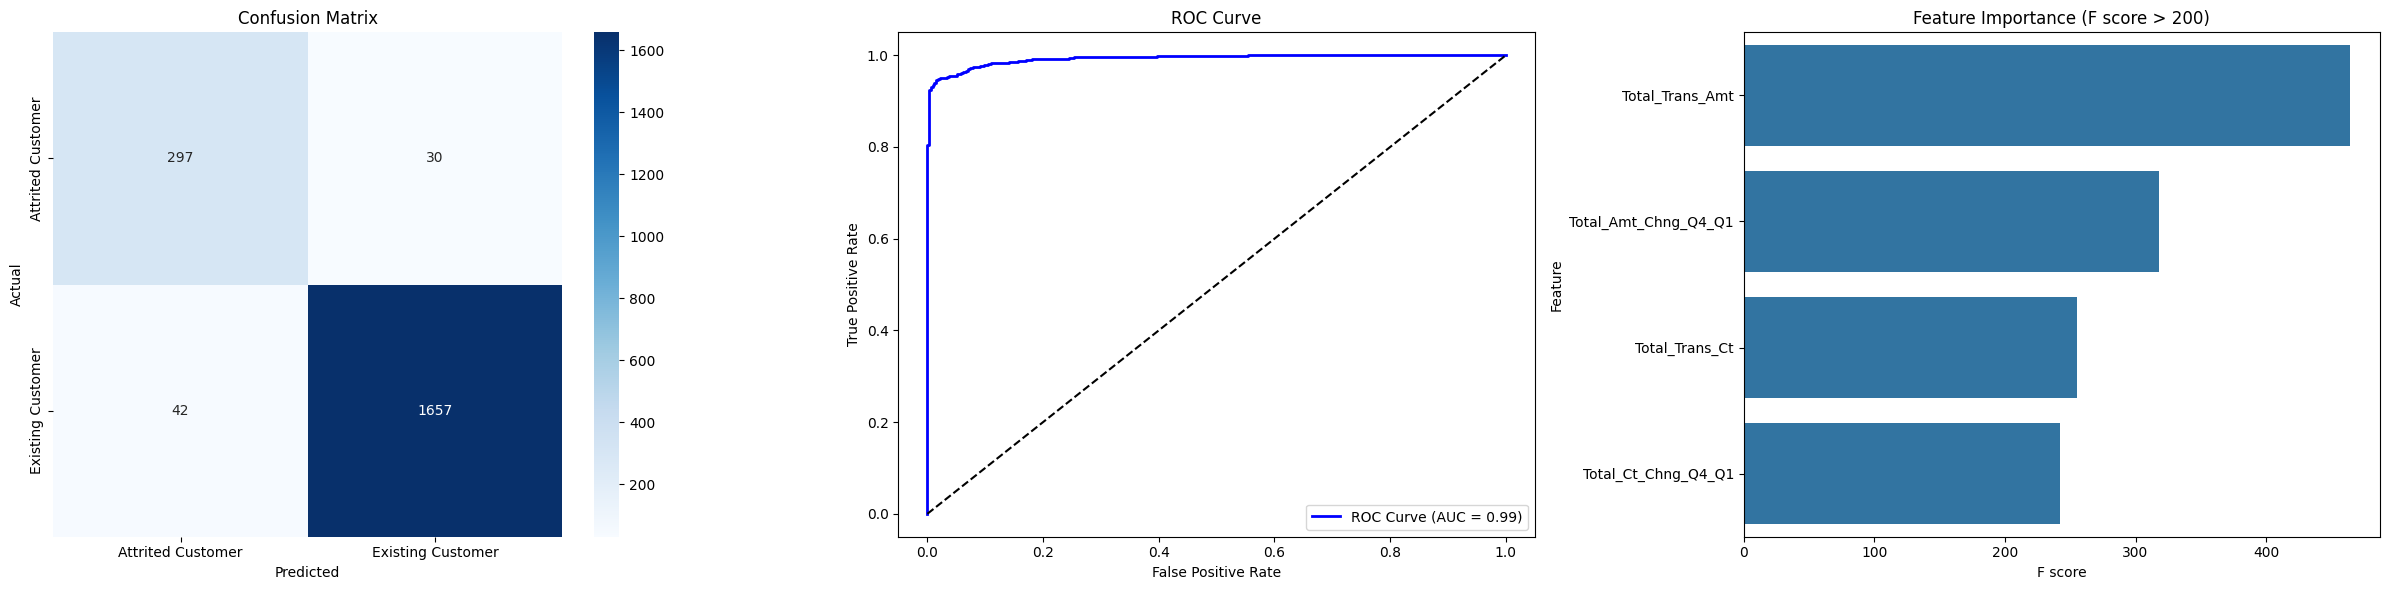

Classification Report (as DataFrame):
              precision    recall  f1-score      support
0              0.876106  0.908257  0.891892   327.000000
1              0.982217  0.975280  0.978736  1699.000000
accuracy       0.964462  0.964462  0.964462     0.964462
macro avg      0.929162  0.941768  0.935314  2026.000000
weighted avg   0.965090  0.964462  0.964719  2026.000000


In [53]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_classification, y_numeric, test_size=0.2, random_state=42)

# Apply RandomOverSampler to balance classes in the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Initialize and train the XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the original test set
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]  # Probability of the positive class (Attrited)

# Generate the confusion matrix and classification report
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

# Create the layout with confusion matrix, ROC curve, and feature importance
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Attrited Customer', 'Existing Customer'], yticklabels=['Attrited Customer', 'Existing Customer'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
axes[1].plot([0, 1], [0, 1], color='black', linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()

# Get feature importances
feature_importances = xgb_model.get_booster().get_score(importance_type='weight')
feature_df = pd.DataFrame({'Feature': list(feature_importances.keys()), 'F_score': list(feature_importances.values())})
feature_df['F_score'] = feature_df['F_score'].astype(int)

# Filter features by F-score > 200
filtered_features = feature_df[feature_df['F_score'] > 200]

# Plot filtered feature importance
sns.barplot(x='F_score', y='Feature', data=filtered_features.sort_values(by='F_score', ascending=False), ax=axes[2])
axes[2].set_title('Feature Importance (F score > 200)')
axes[2].set_xlabel('F score')
axes[2].set_ylabel('Feature')

# Display all the charts together
plt.tight_layout()
plt.show()

# Convert the classification report into a DataFrame
class_report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
print("Classification Report (as DataFrame):")
print(class_report_df)


## Model Evaluation and comparing with RandomForest
1. Accuracy:
- Both models have high accuracy, but XGBoost achieves a higher overall accuracy (96.4% vs. 95.6%).
2. Class-Specific Metrics:
- The Attrited Customer class shows a significant improvement in recall with the XGBoost model (90.8% vs. 82.3% for RandomForest). This suggests that XGBoost, combined with RandomOverSampler, is more effective at identifying true positives in the minority class.
- For the Existing Customer class, both models maintain high precision and recall, but XGBoost has a slightly lower recall than RandomForest (97.5% vs. 98.2%). This is the trade-off where the recall for existing customers decreases while the recall for attrited customers increases.
3. F1-Score:
- The F1-Score for the attrited class is higher with XGBoost (89.2% vs. 85.8% for RandomForest), which shows improved balance between precision and recall.
- For the existing customer class, both models maintain high F1-Scores, indicating strong classification performance.
4. Confusion Matrix:
- XGBoost shows fewer false negatives for attrited customers compared to RandomForest, further highlighting its higher sensitivity for this class.
5. Oversampling Strategy:
- The use of RandomOverSampler improves the classification of attrited customers, who are typically underrepresented. 
- This approach balances the training data and helps the model better learn to recognize patterns in the minority class.

# B. Clustering task

## 1. Clusters using KMeans

In [54]:
# Select relevant data columns for clustering
X_clustering = df.drop(columns=['Attrition_Flag', 'CLIENTNUM'])

# Normalize the data
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X_clustering)

# Determine the optimal number of clusters using silhouette score
best_score = -1
best_k = 2
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_normalized)
    score = silhouette_score(X_normalized, labels)
    if score > best_score:
        best_score = score
        best_k = k

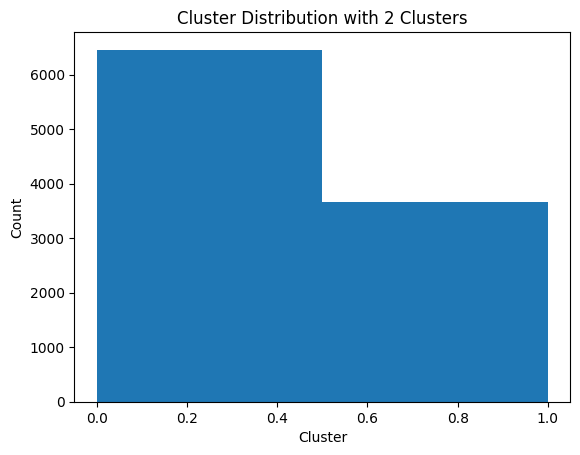

            CLIENTNUM  Customer_Age  Dependent_count  Months_on_book  \
Cluster                                                                
0        7.387806e+08     46.365129         2.266956       35.928306   
1        7.398764e+08     46.257018         2.485691       35.928591   

         Total_Relationship_Count  Months_Inactive_12_mon  \
Cluster                                                     
0                        3.884330                2.354754   
1                        3.686291                2.317253   

         Contacts_Count_12_mon  Credit_Limit  Total_Revolving_Bal  \
Cluster                                                             
0                     2.438526   4069.827222          1192.589037   
1                     2.484873  16661.992614          1110.405560   

         Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  Total_Trans_Amt  \
Cluster                                                           
0            2877.238185              0.756863      409

In [55]:
# Final clustering with the best number of clusters
kmeans = KMeans(n_clusters=best_k, random_state=42)
labels = kmeans.fit_predict(X_normalized)

# Plot the cluster distribution
plt.hist(labels, bins=best_k)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title(f'Cluster Distribution with {best_k} Clusters')
plt.show()

# Add the cluster labels to the original DataFrame
df['Cluster'] = labels

# Group by clusters and compute means of numeric columns
numeric_cols = df.select_dtypes(include=[int, float]).columns
grouped_means = df.groupby('Cluster')[numeric_cols].mean()
print(grouped_means)

## Plot average value across clusters

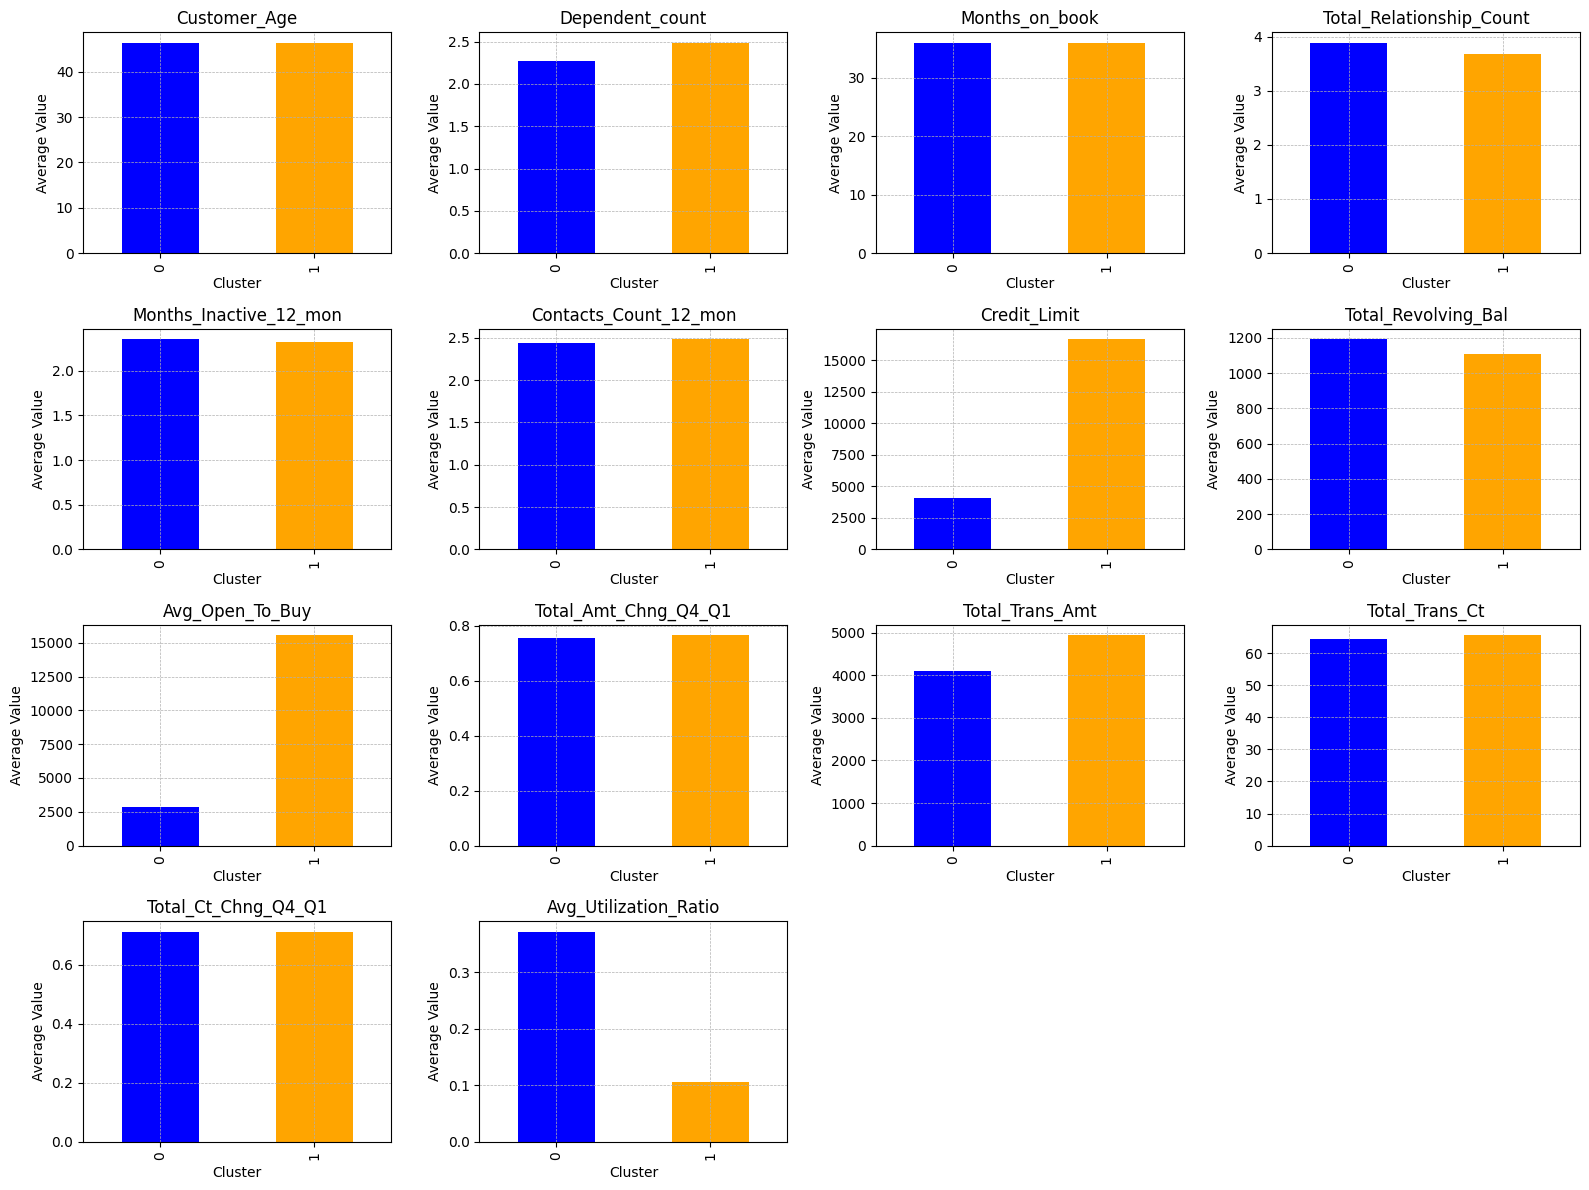

In [56]:
# Select the columns to plot and define the layout parameters
columns_to_plot = [
    'Customer_Age', 'Dependent_count', 'Months_on_book', 'Total_Relationship_Count',
    'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal',
    'Avg_Open_To_Buy', 'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio'
]

# Number of rows and columns for the subplot grid
num_rows = 4
num_cols = 4

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 12))

# Flatten the axes array to iterate over each subplot easily
axes_flat = axes.flatten()

# Plot each column's average value across clusters
for idx, col in enumerate(columns_to_plot):
    ax = axes_flat[idx]
    grouped_means[col].plot(kind='bar', ax=ax, color=['blue', 'orange'])
    ax.set_title(col)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Average Value')
    ax.grid(visible=True, linestyle='--', linewidth=0.5)

# Remove any unused subplots
for i in range(len(columns_to_plot), len(axes_flat)):
    fig.delaxes(axes_flat[i])

# Adjust layout
plt.tight_layout()
plt.show()




### Scatter plot of the two clusters using the selected features

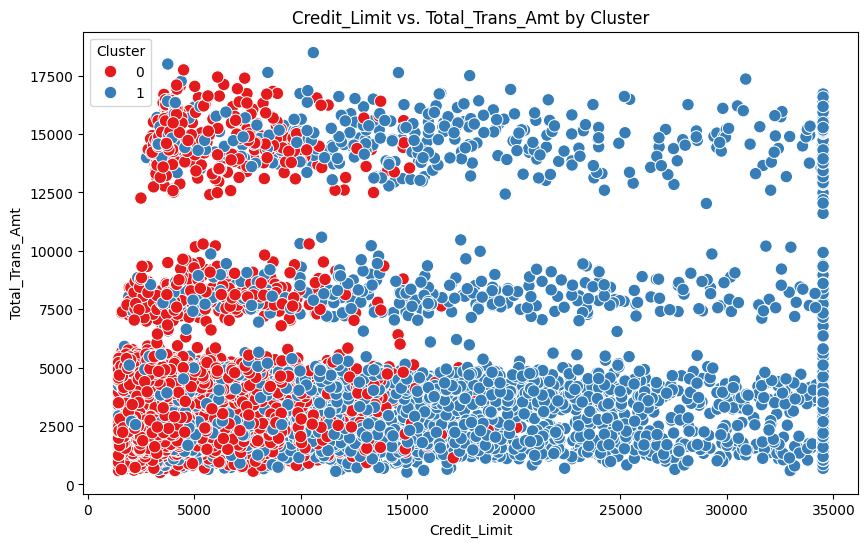

In [57]:
# Select two features for visualization
feature_x = 'Credit_Limit'
feature_y = 'Total_Trans_Amt'

# Scatter plot of the two clusters using the selected features
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x=feature_x, y=feature_y, hue='Cluster', palette='Set1', s=80)
plt.title(f'{feature_x} vs. {feature_y} by Cluster')
plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.legend(title='Cluster', loc='upper left')
plt.show()


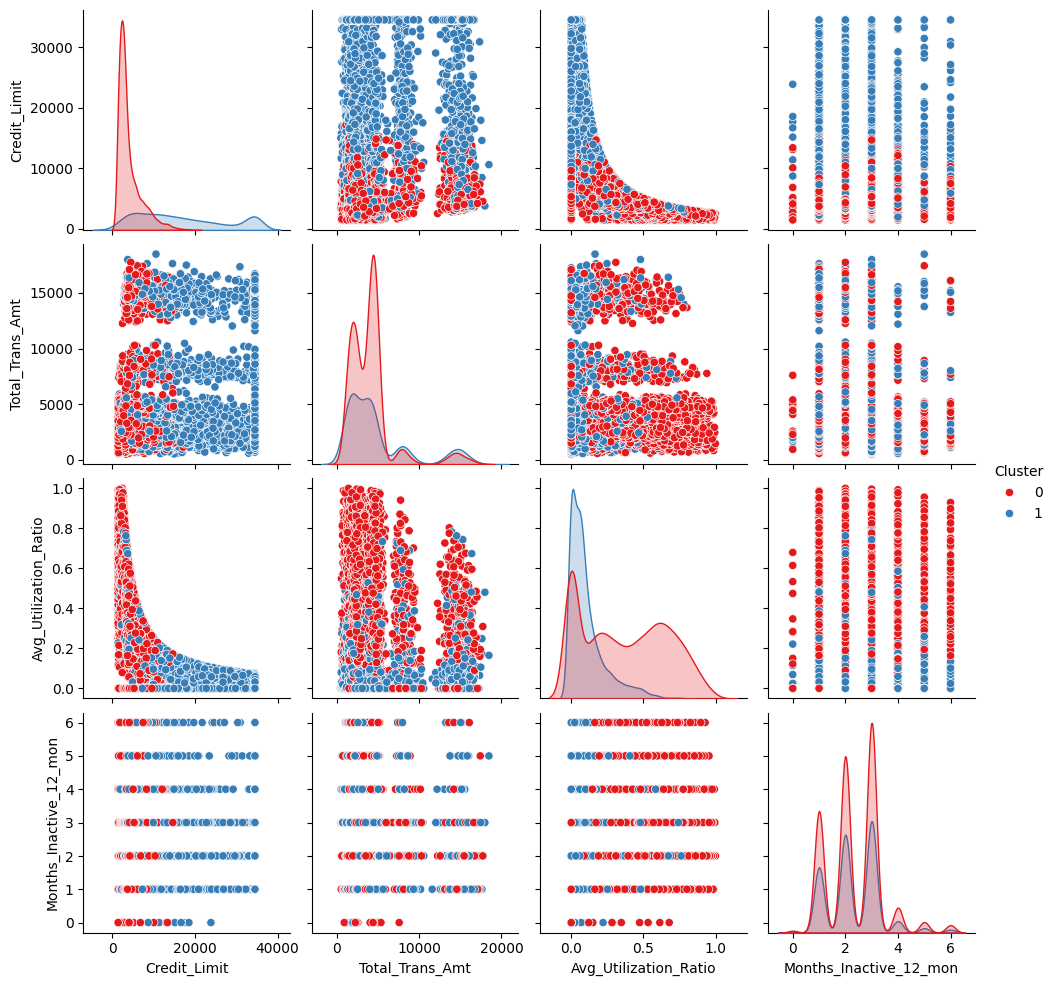

In [58]:
# Select a subset of columns to visualize
columns_to_plot = ['Credit_Limit', 'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Months_Inactive_12_mon', 'Cluster']
sns.pairplot(df[columns_to_plot], hue='Cluster', palette='Set1')
plt.show()


## Cluser results 

1. Cluster Characteristics:
- The two clusters (Cluster 0 and Cluster 1) have different average values for various features, giving each cluster a unique customer profile
- Cluster 0:
    - Lower average credit limit and revolving balance
    - Higher average utilization ratio, suggesting a higher dependency on credit
    - Lower average open-to-buy (credit available after deducting balances)
    - Slightly lower total transaction amount and count
- Cluster 1:
    - Higher average credit limit, indicating higher creditworthiness
    - Lower average utilization ratio, meaning customers are less reliant on credit
    - Higher total transaction amount and count
    - Higher average open-to-buy
2. Interpretation:
- Cluster 0 appears to include customers who are more reliant on their available credit, potentially using their cards more actively and maintaining higher balances.
- Cluster 1 contains customers with higher credit limits who may be less dependent on credit and spend more but maintain lower utilization ratios.
3. Implications:
- Marketing and customer retention strategies can be customized for each cluster.
- Cluster 0 might require more incentives or personalized offers to improve credit behavior and reduce reliance on credit.
- Cluster 1 could be encouraged to expand their services or increase loyalty with reward programs.